## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import Dataset
import pickle
from sklearn.model_selection import train_test_split

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load data

In [2]:
data = pd.read_csv("data/cleaned_static_features.csv",index_col=0)
with open("data/groups.pkl", 'rb') as file:
    groups = pickle.load(file)

In [3]:
disorders = ["Voice Disorders", "Neurological and Neurodegenerative Disorders", "Mood and Psychiatric Disorders","Respiratory Disorders"]
y_voice = data["Voice Disorders"].copy().to_numpy()
X = data.copy().drop(columns=["participant_id", "session_id","task_name"]+disorders).to_numpy()

## Preprocessing

### Average over sessions within subject

In [4]:
n_subj = groups[-1]+1
X_ave = np.zeros((n_subj, X.shape[1]))
y_voice_ave = np.zeros(n_subj)
for g in np.arange(n_subj):
    curr_X = X[np.where(groups==g)].mean(axis=0)
    X_ave[g] = curr_X
    y_voice_ave[g] = y_voice[np.where(groups==g)].mean()
print(X_ave.shape)

(442, 97)


### Normalization

In [5]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_proc = ss.fit_transform(X_ave)

## Train Decision Tree with hyperparameter tuning

In [39]:
# Run GridSearchCV only for Voice disorder and visualize all combinations' train vs validation performance
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def grid_search(param_grid:dict, y_curr, label:str, n_splits:int=10):
    # Split off a held-out test set (never used for CV)
    X_tr, X_te, y_tr, y_te = train_test_split(X_ave, y_curr, test_size=0.15, random_state=42, stratify=y_curr)

    base_dt = DecisionTreeClassifier(random_state=42)
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    gscv = GridSearchCV(base_dt, param_grid, scoring='f1_weighted', cv=skf, n_jobs=-1, refit=True, return_train_score=True)
    gscv.fit(X_tr, y_tr)

    # Convert cv_results_ into a DataFrame for easier analysis
    cv_res = pd.DataFrame(gscv.cv_results_)
    # keep only relevant cols
    cols = ['params','mean_train_score','std_train_score','mean_test_score','std_test_score','rank_test_score']
    summary_grid = cv_res[cols].sort_values('rank_test_score').reset_index(drop=True)

    print('Top 5 hyperparameter combinations (by validation rank):')
    for i, row in summary_grid.head(5).iterrows():
        print(f"Rank {int(row['rank_test_score'])}: val={row['mean_test_score']:.4f}, train={row['mean_train_score']:.4f}, params={row['params']}")

    # Scatter plot: train vs validation for every combo
    fig, ax = plt.subplots(figsize=(8,6))
    x = summary_grid['mean_train_score']
    y = summary_grid['mean_test_score']
    sc = ax.scatter(x, y, c=summary_grid['rank_test_score'], cmap='viridis', s=60, edgecolor='k')
    ax.plot([0,1],[0,1],'--',color='gray',linewidth=1)  # reference line where train==val
    ax.set_xlabel('Mean Train F1 (CV)')
    ax.set_ylabel('Mean Validation F1 (CV)')
    ax.set_title('Train vs Validation F1 for all hyperparameter combinations (Voice)')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Rank (lower is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the overfitting gap (train - val) sorted by rank
    summary_grid['train_minus_val'] = summary_grid['mean_train_score'] - summary_grid['mean_test_score']
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(range(len(summary_grid)), summary_grid['train_minus_val'], color='C1')
    ax.set_xlabel('Hyperparameter combination (sorted by validation rank)')
    ax.set_ylabel('Train F1 - Validation F1')
    ax.set_title('Overfitting gap per hyperparameter combination (Voice)')
    plt.tight_layout()
    plt.show()

    # Evaluate best estimator on held-out test set and show report
    best = gscv.best_estimator_
    y_test_pred = best.predict(X_te)
    test_f1 = f1_score(y_te, y_test_pred, average='weighted')
    print('Classification report (test):')
    print(classification_report(y_te, y_test_pred))
    print('Confusion matrix (test):')
    print(confusion_matrix(y_te, y_test_pred))

    # Save results to a dict for later use
    grid_search_results = {'cv_results_df': summary_grid, 'best_params': gscv.best_params_, 'best_score_cv': gscv.best_score_, 'test_f1': test_f1, 'best_estimator': best}
    return grid_search_results


Top 5 hyperparameter combinations (by validation rank):
Rank 1: val=0.6994, train=0.8145, params={'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}
Rank 2: val=0.6994, train=0.8119, params={'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10}
Rank 3: val=0.6862, train=0.8123, params={'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}
Rank 4: val=0.6803, train=0.8083, params={'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5}
Rank 5: val=0.6803, train=0.8090, params={'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5}


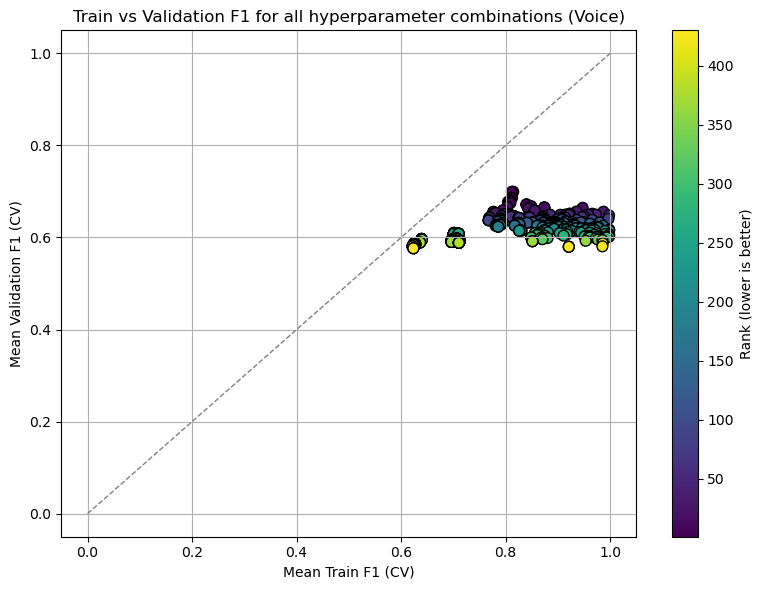

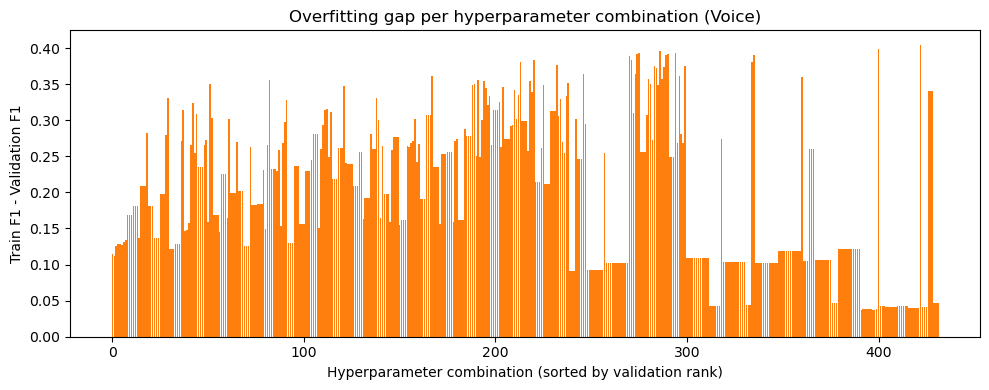

Classification report (test):
              precision    recall  f1-score   support

         0.0       0.58      0.81      0.68        32
         1.0       0.73      0.46      0.56        35

    accuracy                           0.63        67
   macro avg       0.65      0.63      0.62        67
weighted avg       0.66      0.63      0.62        67

Confusion matrix (test):
[[26  6]
 [19 16]]


In [40]:
# Recommended parameter grid for DecisionTreeClassifier (covers regularization and split options)
param_grid = {
    "max_depth": [2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.5, None],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"],
}

grid_search_voice = grid_search(param_grid, y_voice_ave, "Voice")

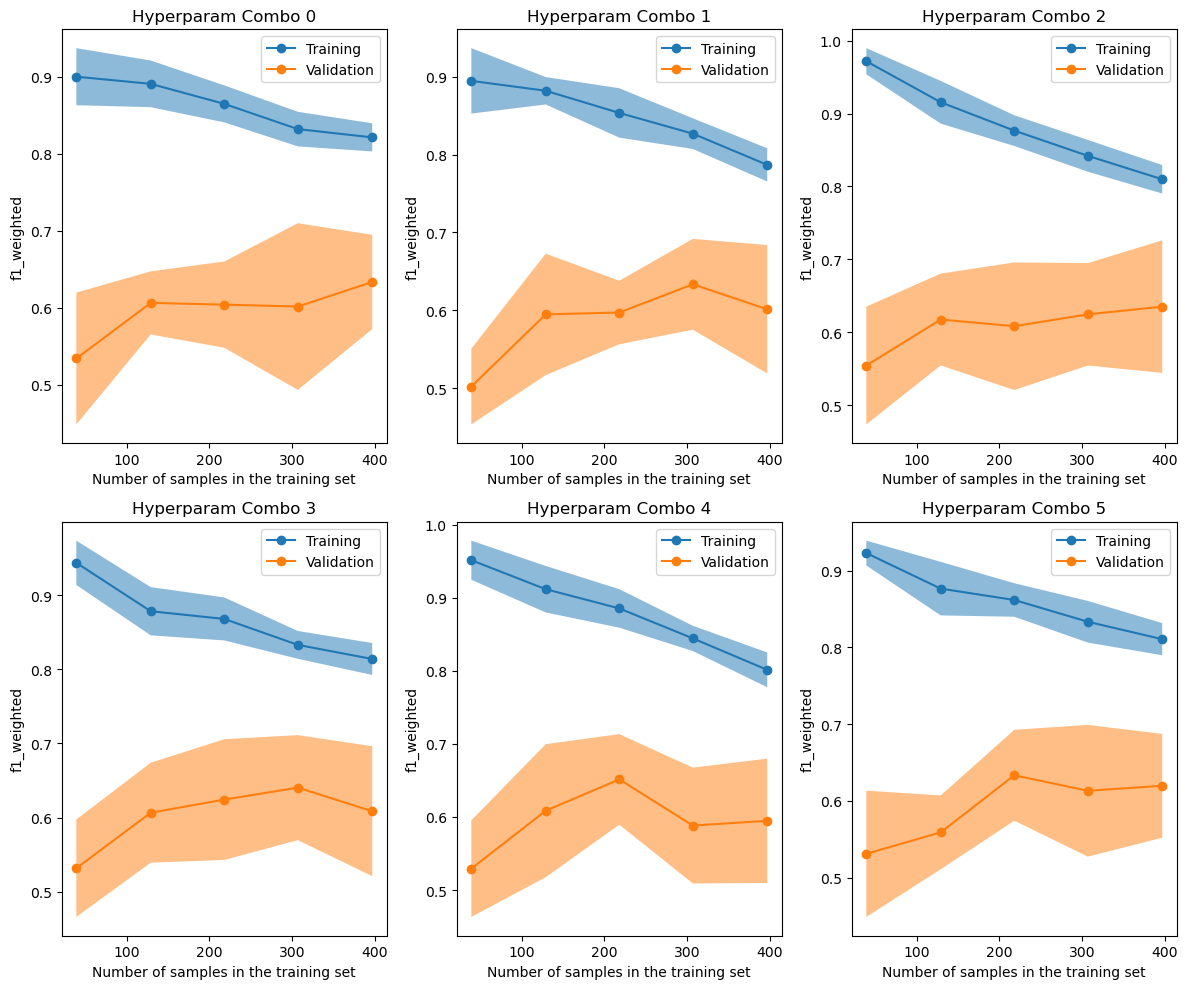

In [41]:
top_params = grid_search_voice["cv_results_df"].sort_values("rank_test_score",ascending=True)[:6]['params'].tolist()

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))

common_params = {
    "X": X_ave,
    "y": y_voice_ave,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "f1_weighted",
}

for i,(ax,params) in enumerate(zip(axes.flatten(), top_params)):
    estimator = DecisionTreeClassifier(**params)
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax)
    
    handles, label = ax.get_legend_handles_labels()
    ax.legend(handles[:2], ["Training", "Validation"])
    ax.set_title(f"Hyperparam Combo {i}") 

plt.tight_layout()
plt.show()

In [53]:
grid_search_voice["cv_results_df"].sort_values(by="train_minus_val",ascending=True)[:10]

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score,train_minus_val
391,"{'class_weight': 'balanced', 'criterion': 'ent...",0.625286,0.048551,0.587774,0.079737,392,0.037511
397,"{'class_weight': 'balanced', 'criterion': 'ent...",0.625286,0.048551,0.587774,0.079737,392,0.037511
398,"{'class_weight': 'balanced', 'criterion': 'ent...",0.625286,0.048551,0.587774,0.079737,392,0.037511
392,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
393,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
394,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
395,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
396,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
399,"{'class_weight': 'balanced', 'criterion': 'ent...",0.626532,0.048800,0.587774,0.079737,392,0.038758
418,"{'class_weight': None, 'criterion': 'entropy',...",0.623456,0.047262,0.584026,0.074952,417,0.039430


In [54]:
grid_search_voice["cv_results_df"].sort_values(by="rank_test_score",ascending=True)[:10]

,params,mean_train_score,std_train_score,mean_test_score,std_test_score,rank_test_score,train_minus_val
0,"{'class_weight': None, 'criterion': 'gini', 'm...",0.814549,0.012367,0.699443,0.072922,1,0.115105
1,"{'class_weight': None, 'criterion': 'gini', 'm...",0.811870,0.013630,0.699403,0.066210,2,0.112467
2,"{'class_weight': None, 'criterion': 'gini', 'm...",0.812263,0.015451,0.686244,0.088751,3,0.126019
3,"{'class_weight': None, 'criterion': 'gini', 'm...",0.808339,0.015994,0.680277,0.090743,4,0.128062
4,"{'class_weight': 'balanced', 'criterion': 'gin...",0.809009,0.020819,0.680269,0.093848,5,0.128740
5,"{'class_weight': 'balanced', 'criterion': 'gin...",0.804491,0.022542,0.677200,0.097413,6,0.127291
6,"{'class_weight': 'balanced', 'criterion': 'gin...",0.806638,0.022779,0.675002,0.078838,7,0.131637
7,"{'class_weight': 'balanced', 'criterion': 'gin...",0.809066,0.020874,0.674741,0.092293,8,0.134325
8,"{'class_weight': None, 'criterion': 'gini', 'm...",0.839897,0.011228,0.671688,0.058739,9,0.168209
9,"{'class_weight': None, 'criterion': 'gini', 'm...",0.839897,0.011228,0.671688,0.058739,9,0.168209


### Let's try out the model without group averaged data

In [56]:
# Preprocess, train, and evaluate DecisionTree with LOGO and record per-fold train/val metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

ss = StandardScaler()
X_full_proc = ss.fit_transform(X)

logo = LeaveOneGroupOut()
fold_results = []

best_params = {'class_weight': None, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}

for fold_idx, (train_idx, test_idx) in enumerate(logo.split(X_full_proc, y_voice, groups=groups)):
    # Train/validation split at group level
    X_tr, y_tr = X_full_proc[train_idx], y_voice[train_idx]
    X_val, y_val = X_full_proc[test_idx], y_voice[test_idx]

    clf = DecisionTreeClassifier(random_state=42, **best_params)

    # Fit on training groups
    clf.fit(X_tr, y_tr)

    # Evaluate on training groups (report group-level aggregated performance)
    y_tr_pred = clf.predict(X_tr)
    train_f1 = f1_score(y_tr, y_tr_pred, average='weighted')

    # Evaluate on held-out group (validation)
    y_val_pred = clf.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    fold_results.append({
        'fold': fold_idx,
        'train_idx_count': len(train_idx),
        'val_idx_count': len(test_idx),
        'train_f1': train_f1,
        'val_f1': val_f1,
        'val_groups': np.unique(groups[test_idx]).tolist()
    })

# Convert to DataFrame for easier plotting/analysis
decision_tree_logo_fold_results = pd.DataFrame(fold_results)
print('Per-fold LOGO results (first 10 rows):')
print(decision_tree_logo_fold_results.head(10))


Per-fold LOGO results (first 10 rows):
   fold  train_idx_count  val_idx_count  train_f1    val_f1 val_groups
0     0            19191             47  0.628633  0.676056        [0]
1     1            19062            176  0.628616  0.942943        [1]
2     2            19199             39  0.626599  0.266667        [2]
3     3            19198             40  0.626532  0.688525        [3]
4     4            19198             40  0.597904  0.974359        [4]
5     5            19198             40  0.616750  0.730159        [5]
6     6            19198             40  0.618518  0.787879        [6]
7     7            19196             42  0.593912  0.962963        [7]
8     8            19204             34  0.598758  0.553191        [8]
9     9            19198             40  0.598229  0.904110        [9]


In [57]:
decision_tree_logo_fold_results

,fold,train_idx_count,val_idx_count,train_f1,val_f1,val_groups
0,0,19191,47,0.628633,0.676056,[0]
1,1,19062,176,0.628616,0.942943,[1]
2,2,19199,39,0.626599,0.266667,[2]
3,3,19198,40,0.626532,0.688525,[3]
4,4,19198,40,0.597904,0.974359,[4]
...,...,...,...,...,...,...
437,437,19197,41,0.627648,0.861111,[437]
438,438,19204,34,0.624860,0.847458,[438]
439,439,19196,42,0.625511,0.962963,[439]
440,440,19190,48,0.626938,0.684932,[440]


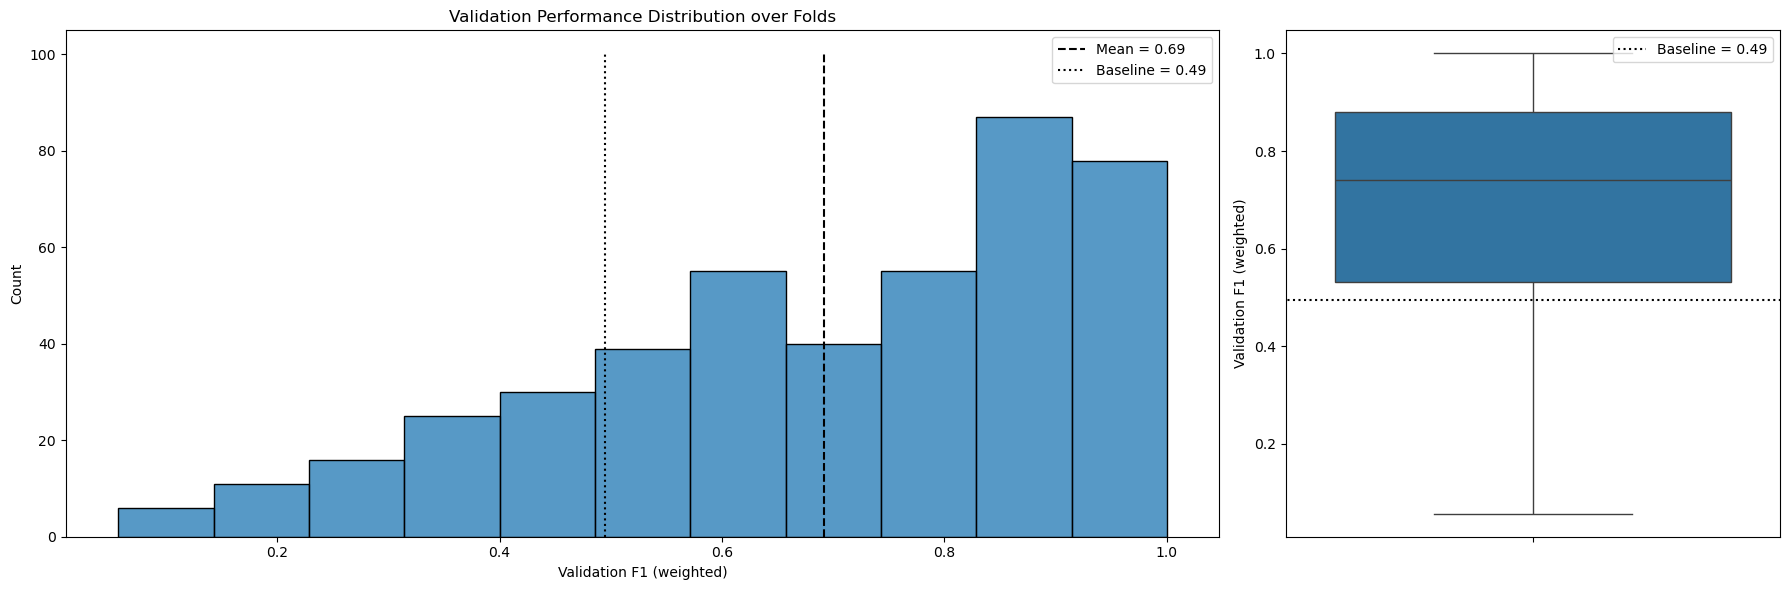

In [58]:
import seaborn as sns

val_mean = decision_tree_logo_fold_results["val_f1"].mean()
baseline_mean = y_voice.mean()

fig,axes = plt.subplots(1,2,figsize=(18,6),width_ratios=[0.7,0.3])

sns.histplot(data=decision_tree_logo_fold_results,x="val_f1",ax=axes[0])
axes[0].plot([val_mean, val_mean], [0, 100], ls="--",c="k",label=f"Mean = {np.round(val_mean, 2)}")
axes[0].plot([baseline_mean, baseline_mean], [0, 100], ls="dotted",c="k",label=f"Baseline = {np.round(baseline_mean, 2)}")
axes[0].set_xlabel("Validation F1 (weighted)")
axes[0].legend()
axes[0].set_title("Validation Performance Distribution over Folds")

sns.boxplot(data=decision_tree_logo_fold_results, y="val_f1",ax=axes[1])
axes[1].plot([-1,2], [baseline_mean, baseline_mean], ls="dotted", c="k", label=f"Baseline = {np.round(baseline_mean,2)}")
axes[1].set_ylabel("Validation F1 (weighted)")
axes[1].set_xlim([-0.5, 0.5])
axes[1].legend()
plt.tight_layout()
plt.show()

## Group K Fold
- Leave one group out is making the model overfit because the test folds are too small. Let's try leaving out more groups than one.

In [84]:
# Preprocess, train, and evaluate DecisionTree with LOGO and record per-fold train/val metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd

ss = StandardScaler()
X_full_proc = ss.fit_transform(X)

gkf = GroupKFold(n_splits=50,shuffle=False)
fold_results = []

for fold_idx, (train_idx, test_idx) in enumerate(gkf.split(X_full_proc, y_voice, groups=groups)):
    # Train/validation split at group level
    X_tr, y_tr = X_full_proc[train_idx], y_voice[train_idx]
    X_val, y_val = X_full_proc[test_idx], y_voice[test_idx]

    clf = DecisionTreeClassifier(random_state=42, **best_params)

    # Fit on training groups
    clf.fit(X_tr, y_tr)

    # Evaluate on training groups (report group-level aggregated performance)
    y_tr_pred = clf.predict(X_tr)
    train_f1 = f1_score(y_tr, y_tr_pred, average='weighted')

    # Evaluate on held-out group (validation)
    y_val_pred = clf.predict(X_val)
    val_f1 = f1_score(y_val, y_val_pred, average='weighted')

    fold_results.append({
        'fold': fold_idx,
        'train_idx_count': len(train_idx),
        'val_idx_count': len(test_idx),
        'train_f1': train_f1,
        'val_f1': val_f1,
        'val_groups': np.unique(groups[test_idx]).tolist()
    })

# Convert to DataFrame for easier plotting/analysis
decision_tree_gkf_fold_results = pd.DataFrame(fold_results)
print('Per-fold GKF results (first 10 rows):')
print(decision_tree_gkf_fold_results.head(10))


Per-fold GKF results (first 10 rows):
   fold  train_idx_count  val_idx_count  train_f1    val_f1  \
0     0            18839            399  0.633103  0.672562   
1     1            18844            394  0.625227  0.694744   
2     2            18847            391  0.626400  0.621357   
3     3            18847            391  0.606672  0.605715   
4     4            18847            391  0.594998  0.507373   
5     5            18849            389  0.629464  0.520554   
6     6            18839            399  0.598156  0.587711   
7     7            18843            395  0.616679  0.691252   
8     8            18846            392  0.599470  0.516724   
9     9            18846            392  0.626123  0.596939   

                                 val_groups  
0           [1, 61, 65, 158, 397, 415, 421]  
1         [17, 94, 125, 183, 276, 293, 409]  
2        [29, 136, 166, 207, 215, 248, 307]  
3        [38, 144, 150, 268, 334, 380, 408]  
4        [26, 117, 156, 226, 270, 369,

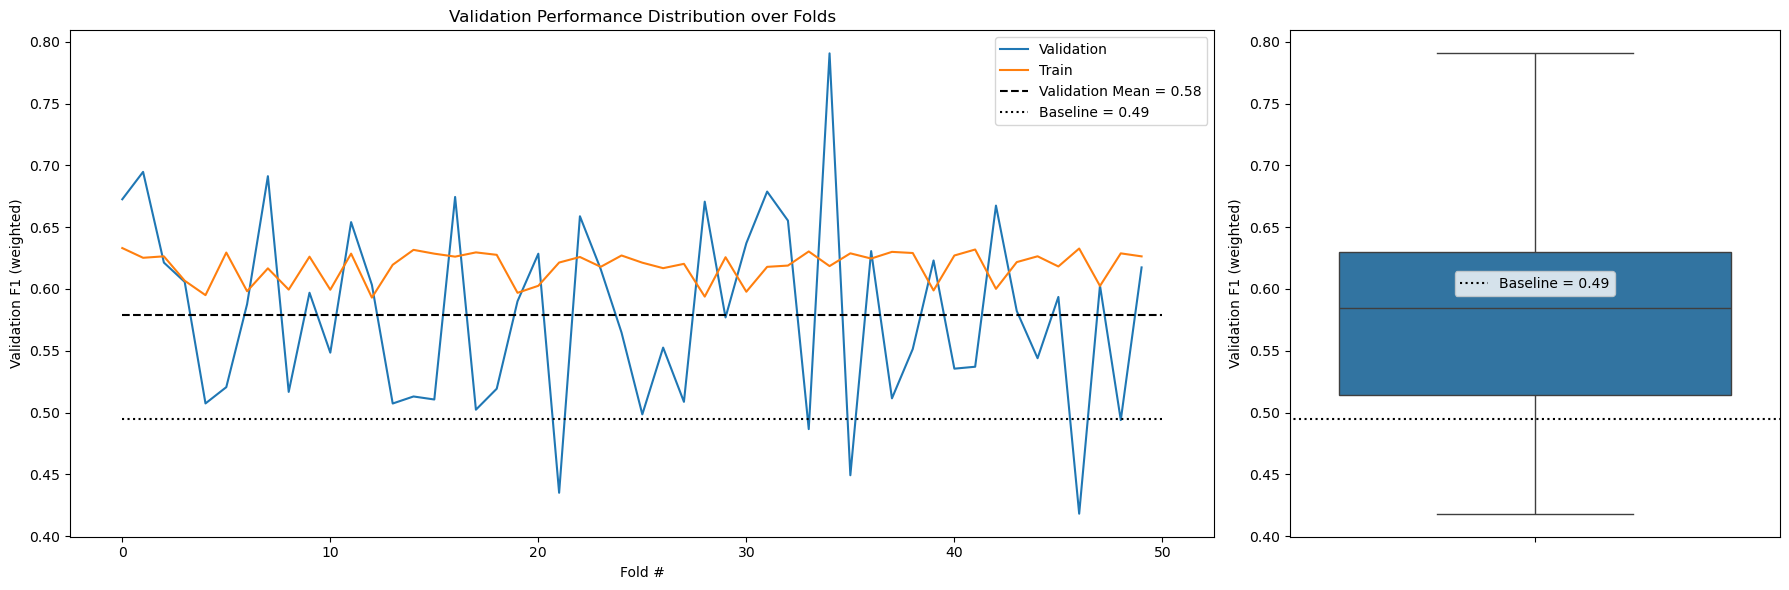

In [85]:
import seaborn as sns

val_mean = decision_tree_gkf_fold_results["val_f1"].mean()
baseline_mean = y_voice.mean()

fig,axes = plt.subplots(1,2,figsize=(18,6),width_ratios=[0.7,0.3])

sns.lineplot(data=decision_tree_gkf_fold_results,x="fold",y="val_f1",ax=axes[0],label="Validation")
sns.lineplot(data=decision_tree_gkf_fold_results,x="fold",y="train_f1",ax=axes[0],label="Train")
axes[0].plot([0,50],[val_mean, val_mean], ls="--",c="k",label=f"Validation Mean = {np.round(val_mean, 2)}")
axes[0].plot([0,50],[baseline_mean, baseline_mean], ls="dotted",c="k",label=f"Baseline = {np.round(baseline_mean, 2)}")
axes[0].set_ylabel("Validation F1 (weighted)")
axes[0].set_xlabel("Fold #")
axes[0].legend()
axes[0].set_title("Validation Performance Distribution over Folds")

sns.boxplot(data=decision_tree_gkf_fold_results, y="val_f1",ax=axes[1])
axes[1].plot([-1,2], [baseline_mean, baseline_mean], ls="dotted", c="k", label=f"Baseline = {np.round(baseline_mean,2)}")
axes[1].set_ylabel("Validation F1 (weighted)")
axes[1].set_xlim([-0.5, 0.5])
axes[1].legend()
plt.tight_layout()
plt.show()

## Hyperparameter tuning with GroupKFold

In [90]:
# Run GridSearchCV only for Voice disorder and visualize all combinations' train vs validation performance
from sklearn.model_selection import GridSearchCV, GroupKFold, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def grid_search(param_grid:dict, X, y, groups, label:str, n_splits:int=50):
    base_dt = DecisionTreeClassifier(random_state=42)

    gkf = GroupKFold(n_splits=n_splits)

    gscv = GridSearchCV(base_dt, param_grid, scoring='f1_weighted', cv=gkf, n_jobs=-1, refit=True, return_train_score=True)
    gscv.fit(X, y, groups=groups)

    # Convert cv_results_ into a DataFrame for easier analysis
    cv_res = pd.DataFrame(gscv.cv_results_)
    # keep only relevant cols
    cols = ['params','mean_train_score','std_train_score','mean_test_score','std_test_score','rank_test_score']
    summary_grid = cv_res[cols].sort_values('rank_test_score').reset_index(drop=True)

    print('Top 5 hyperparameter combinations (by validation rank):')
    for i, row in summary_grid.head(5).iterrows():
        print(f"Rank {int(row['rank_test_score'])}: val={row['mean_test_score']:.4f}, train={row['mean_train_score']:.4f}, params={row['params']}")

    # Scatter plot: train vs validation for every combo
    fig, ax = plt.subplots(figsize=(8,6))
    x = summary_grid['mean_train_score']
    y = summary_grid['mean_test_score']
    sc = ax.scatter(x, y, c=summary_grid['rank_test_score'], cmap='viridis', s=60, edgecolor='k')
    ax.plot([0,1],[0,1],'--',color='gray',linewidth=1)  # reference line where train==val
    ax.set_xlabel('Mean Train F1 (CV)')
    ax.set_ylabel('Mean Validation F1 (CV)')
    ax.set_title('Train vs Validation F1 for all hyperparameter combinations (Voice)')
    cbar = plt.colorbar(sc, ax=ax)
    cbar.set_label('Rank (lower is better)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the overfitting gap (train - val) sorted by rank
    summary_grid['train_minus_val'] = summary_grid['mean_train_score'] - summary_grid['mean_test_score']
    fig, ax = plt.subplots(figsize=(10,4))
    ax.bar(range(len(summary_grid)), summary_grid['train_minus_val'], color='C1')
    ax.set_xlabel('Hyperparameter combination (sorted by validation rank)')
    ax.set_ylabel('Train F1 - Validation F1')
    ax.set_title('Overfitting gap per hyperparameter combination (Voice)')
    plt.tight_layout()
    plt.show()

    # Evaluate best estimator on held-out test set and show report
    best = gscv.best_estimator_

    # Save results to a dict for later use
    grid_search_results = {'cv_results_df': summary_grid, 'best_params': gscv.best_params_, 'best_score_cv': gscv.best_score_, 'best_estimator': best}
    return grid_search_results


Top 5 hyperparameter combinations (by validation rank):
Rank 1: val=0.6409, train=0.6420, params={'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 10, 'min_samples_split': 10}
Rank 1: val=0.6409, train=0.6420, params={'class_weight': None, 'criterion': 'entropy', 'max_depth': 2, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Rank 1: val=0.6409, train=0.6420, params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 10}
Rank 1: val=0.6409, train=0.6420, params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Rank 1: val=0.6409, train=0.6420, params={'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 2, 'max_features': 0.5, 'min_samples_leaf': 2, 'min_samples_split': 5}


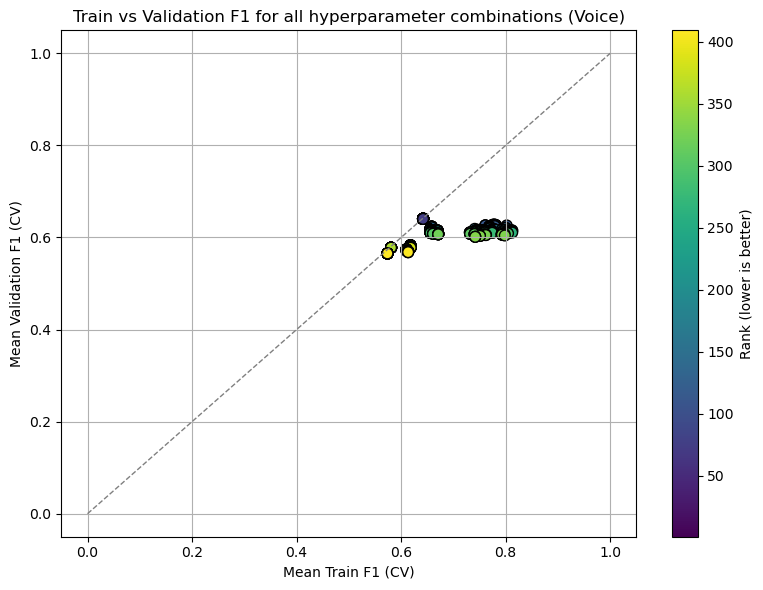

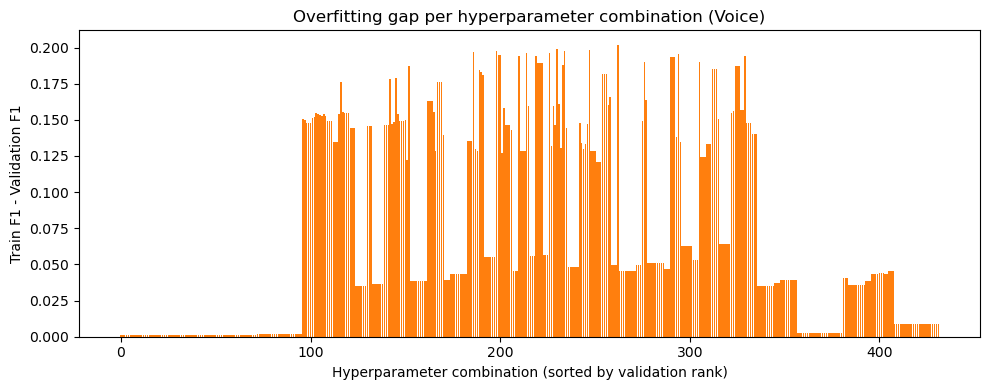

In [91]:
# Recommended parameter grid for DecisionTreeClassifier (covers regularization and split options)
param_grid = {
    "max_depth": [2, 5, 10],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 5, 10],
    "max_features": ["sqrt", 0.5, None],
    "criterion": ["gini", "entropy"],
    "class_weight": [None, "balanced"],
}

grid_search_voice = grid_search(param_grid, X_full_proc, y_voice, groups, "Voice")